In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from scipy.stats import linregress
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

import matplotlib.transforms as mtransforms
from matplotlib.patches import FancyArrowPatch

In [3]:
delE=4.5
Ka=1.4*10**(-4)
Ki=5.3*10**(-7)
K_c=Ka/Ki

fixed_r0 = 0.1
fixed_r1 = 1
fixed_r2 = 20
fixed_w = 7
fixed_gamma = 1

pact = 0.07

custom_cmap = ListedColormap(["#FFCCCC", "#ADD8E6"])

# helper functions
def pAct(c, K_c=K_c, delE=delE):
    """ probability of repressor/activator being active

    Parameters:
        - c: inducer concentration
        - K_c: dissociation constant in active state / dissociation constant in inactive state
        - delE: energy difference between inactive and active state
    """

    p= (1 + c)**2 / ((1 + c)**2 + np.exp(-delE)*(1 + c*K_c)**2)
    return p

def pAct_inv(p, K_c=K_c, delE=delE):
    """Inverse of pAct: returns inducer concentration c given activation probability p"""
    a = np.sqrt(1/p - 1) * np.exp(delE / 2)
    c = (a - 1) / (K_c - a)
    return c
print('c = '+str(pAct_inv(0.07, K_c=K_c, delE=delE)*Ka))

c = 2.0479873960782143e-05


## Dynamical equation

$$
\frac{d\tilde{A}}{d\tilde{t}}=-\gamma \tilde{A} + \frac{r_0+2r_1p_{act}\tilde{A}+r_2 \omega(p_{act}\tilde{A})^2}{1+2p_{act}\tilde{A}+\omega(p_{act}\tilde{A})^2}
$$





In [5]:
def f_prime(A, pAct=0.07, r0=fixed_r0, r1=fixed_r1, r2=fixed_r2, omega=fixed_w, gamma=fixed_gamma):
    return -gamma + (2 * pAct * (-r0 + r1 + A * pAct * (-r0 + r2 + A * pAct * (-r1 + r2)) * omega)) / \
                   (1 + A * pAct * (2 + A * pAct * omega))**2

In [7]:
def is_stable(A, pact, w, r0, r1, r2):
  same_sign_than_fprime = (-1 + pact * (-4 * A * (1 + A * pact) - 2 * r0 + 2 * r1 -
                      2 * A * pact * (A + r0 + A * pact * (2 * A + r1 - r2) -
                      r2) * w - A**4 * pact**3 * w**2))
  if same_sign_than_fprime>0:
    return True
  else:
    return False

In [9]:
# polynomial giving the steady states
def polynomial_coefficients(pact, w, r0, r1, r2):
    return [w * pact**2,
            (2 * pact - w * r2 * pact**2),
            (1 - 2 * r1 * pact),
            -r0]

# Function to find roots for varying pact
def find_real_positive_roots(pact, w, r0, r1, r2):
    coeffs = polynomial_coefficients(pact, w, r0, r1, r2)
    roots = np.roots(coeffs)
    # Filter for real and positive roots
    real_positive_roots = roots[np.isreal(roots) & (roots > 0)]
    return real_positive_roots

In [11]:
def auto_act_A_t_profile(initial_conditions, pact=0.07, w=fixed_w, r0=fixed_r0, r1=fixed_r1, r2=fixed_r2):
  def system(t, A):
    dA_dt = -A + (r0 + 2 * r1 *pact*A + r2*w*(pact*A)**2 ) / (1+ 2*pact*A + w*(pact*A)**2)
    return [dA_dt]
  t_span = (0, 20)  # Solve from t=0 to t=100
  t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Points at which to evaluate the solution

  # Solve the system of equations
  solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval)

  # Extract the solution at long time (last time point)
  A_of_t = solution.y[0]

  return A_of_t, t_eval


In [13]:
def time_scale(seady_states,f_of_t,time,type_of_approach='curve_fit',thresh=0.63):
  f_0=f_of_t[0]
  f_inf=f_of_t[-1]
  t_0=time[0]
  i_ss = np.argmin(np.abs(f_inf-seady_states))
  A_inf = seady_states[i_ss]
  if type_of_approach == 'curve_fit':
    #y=np.log(np.abs(f_of_t-A_inf))
    def exp_relax(t, tau):
      return A_inf + (f_0 - A_inf) * np.exp(-(t-t_0) / tau)
    popt, pcov = curve_fit(exp_relax, time, f_of_t, p0=[1])
    tau_fit = popt
    return tau_fit
  if type_of_approach == 'threshold':
    f_target = thresh * (f_inf-f_0) + f_0
    i_t = np.argmin(np.abs(f_of_t - f_target))
    return time[i_t]



## time scales

In [15]:
A_fixed_points = find_real_positive_roots(pact, fixed_w, fixed_r0, fixed_r1, fixed_r2)
A1,A3=min(A_fixed_points),max(A_fixed_points)
A0_max=A3*20

In [17]:
#define a list of A0, with points which are not too close from stable steady state to avoid absence of transient
index_to_remove = []
A0_list=np.logspace(-2 , np.log10(A0_max), 1000)
for i in range(len(A0_list)):
  if abs(A0_list[i]-A1)<1e-3 or abs(A0_list[i]-A3)<1e-2:
    index_to_remove += [i]

index_to_remove = np.array(index_to_remove)
A0_list = np.delete(A0_list, index_to_remove)

In [19]:
# we compute fixed points
A_fixed_points = find_real_positive_roots(pact, fixed_w, fixed_r0, fixed_r1, fixed_r2)
A1,A3=min(A_fixed_points),max(A_fixed_points)
# we compute the relaxation times
tau_A_cf_list = []
for iA0 in range(len(A0_list)):
  A0 = A0_list[iA0]
  A_of_t, time = auto_act_A_t_profile([A0])
  tau_A_cf = time_scale(A_fixed_points,A_of_t,time,type_of_approach='curve_fit')
  tau_A_cf_list += [tau_A_cf]

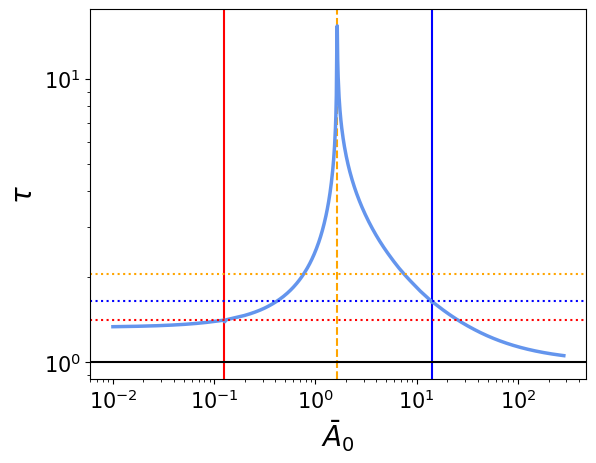

In [21]:
plt.axvline(A_fixed_points[0], color ='b', label = ' stable fixed point')
plt.axvline(A_fixed_points[1], color='orange', linestyle = '--', label = ' unstable fixed point')
plt.axvline(A_fixed_points[2],color='r')

plt.plot(A0_list,tau_A_cf_list, color = "cornflowerblue", label = 'curve fit', linewidth=2.5)

tau_0=1/np.abs(f_prime(A_fixed_points[0]))
tau_1=1/np.abs(f_prime(A_fixed_points[1]))
tau_2=1/np.abs(f_prime(A_fixed_points[2]))

plt.axhline(tau_0, color ='b', linestyle=':')
plt.axhline(tau_1, color='orange', linestyle=':')
plt.axhline(tau_2,color='r', linestyle=':')
plt.axhline(1,color='k', label=r'$\gamma$')

plt.tick_params(axis='both', which='major', labelsize=15) 
plt.xlabel(r'$\bar{A}_0$',size=20)
plt.ylabel(r'$\tau$',size=20)
plt.xscale('log')
plt.yscale('log')


## Example of relaxation

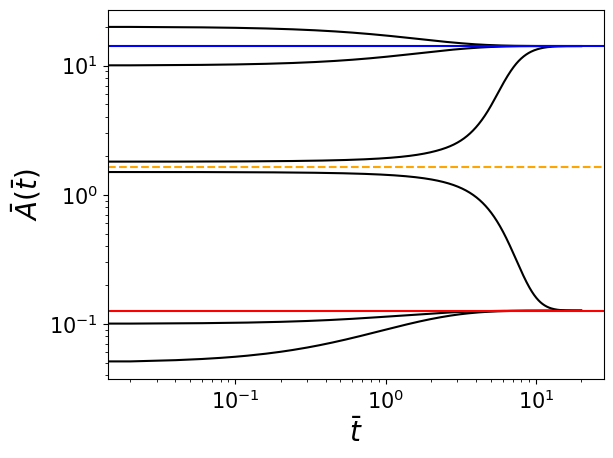

In [23]:
A0_05,t=auto_act_A_t_profile([0.05], pact)
A0_1,t=auto_act_A_t_profile([0.1], pact)
A1_5,t=auto_act_A_t_profile([1.5], pact)
A1_8,t=auto_act_A_t_profile([1.8], pact)
A14,t=auto_act_A_t_profile([10], pact)
A15,t=auto_act_A_t_profile([20], pact)
plt.plot(t,A0_05 ,'k')
plt.plot(t,A0_1, 'k')
plt.plot(t,A1_5, 'k')
plt.plot(t,A1_8, 'k')
plt.plot(t,A14, 'k')
plt.plot(t,A15, 'k')
plt.xscale('log')
plt.yscale('log')

plt.ylabel(r'$\bar{A}(\bar{t})$',size=20)
plt.xlabel(r'$\bar{t}$',size=20)

plt.tick_params(axis='both', which='major', labelsize=15)  # adjust tick label size

plt.axhline(A_fixed_points[0], color ='b', label = ' stable fixed point')
plt.axhline(A_fixed_points[1], color='orange', linestyle = '--', label = ' unstable fixed point')
plt.axhline(A_fixed_points[2],color='r')

## Comparaison between threshold approach and curve fit

In [25]:
list_thresh = np.linspace(0.5, 0.99, 10)
tau_A_cf_list = []
tau_A_thresh_list = np.zeros((len(list_thresh),len(A0_list)))
norm = mcolors.Normalize(vmin=0, vmax=len(list_thresh))

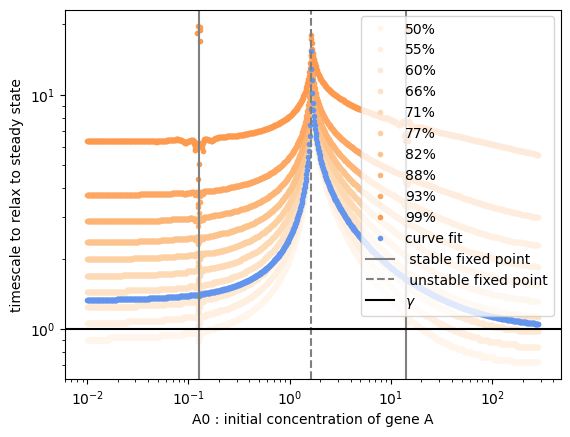

In [27]:
for it in range(len(list_thresh)):
  t = list_thresh[it]
  for iA0 in range(len(A0_list)):
    A0 = A0_list[iA0]
    A_of_t, time = auto_act_A_t_profile([A0])
    tau_A_thresh = time_scale(A_fixed_points,A_of_t,time,type_of_approach='threshold',thresh=t)
    if it==0:
      tau_A_cf = time_scale(A_fixed_points,A_of_t,time,type_of_approach='curve_fit')
      tau_A_cf_list += [tau_A_cf]
    tau_A_thresh_list[it][iA0] = tau_A_thresh
  c = plt.cm.Oranges(norm(it) * 0.5)
  plt.plot(A0_list,tau_A_thresh_list[it], marker = '.', color = c, linestyle='None', label = str(int(t*100))+'%')

plt.plot(A0_list,tau_A_cf_list, marker = '.', color = "cornflowerblue", linestyle='None', label = 'curve fit')

plt.xlabel('A0 : initial concentration of gene A')
plt.ylabel('timescale to relax to steady state')
plt.xscale('log')
plt.yscale('log')

plt.axvline(A_fixed_points[0], color ='gray', label = ' stable fixed point')
plt.axvline(A_fixed_points[1], color='gray', linestyle = '--', label = ' unstable fixed point')
plt.axvline(A_fixed_points[2],color='gray')

plt.axhline(1,color='k', label=r'$\gamma$')

plt.legend()